In [24]:
import numpy as np
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

# Auxiliary Functions

In [25]:
# Define RBF kernel
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs =jnp.expand_dims(x1 / lengthscales, 1) - \
           jnp.expand_dims(x2 / lengthscales, 0)
    r2 =jnp.sum(diffs**2, axis=2)
    return output_scale *jnp.exp(-0.5 * r2)

In [26]:
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='black'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'o-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x',fontsize='large')
  ax1.set_ylabel('u',fontsize='large')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)

# **Introduction**

## **Functions and Operators:**

### **Function:**

 Maps between vector spaces:

*Example:*

Let $f_1(x)=sin(x)$; for  $x\in\mathbf{R}$

$$z=f_1(x)=sin(x)\in[0:1]$$

In other words $f_1$ maps $\mathbf{R}→[0,1]$

### **Operator:**

 Maps between infite-dimensional function spaces:
$$G(f_1(x))=f_2(x)$$

*Example:*

Derivative Operator →$\frac{d}{d x}$

It transforms a funcion $f_1$ into a function $f_2$:

Let $f_1(x)=sin(x)$

Then when we apply our operator:

$$f_2=\frac{df_1(x)}{d x}=\frac{d}{d x}sin(x)=cos(x)$$


### **Parametric PDEs and Operators**

Parametric PDEs $\rightarrow$ Some parameters (e.g., shape, IC/BC, coefficients, etc.) of a given PDE system are allowed to change.

Let  $\mathcal{N}$ be a nonlinear operator. Let's consider a parametric PDEs of the form:

$$\mathcal{N}(u,s)=0$$

Where $u$ is the input function and $s$ is the unknown PDE's solution (also a function).

Our PDE solution operator would be:

$$G(u)=s$$

**Note 1:**I other words, we can express the general solution of our PDE as an operator $G$

**Note 2:** Remember $s$ is itself a function, so if we evaluate it at any point $y$, the answer would be a real number:

 $$G(u)(y)=s(y)\in \mathbf{R}$$

 ### **Universal Approximation Theorem for Operator**

 $\forall \epsilon >0$, there are positive integers $n,p,m$, constants $c_i^k,W_{bij}^k,b_{bij}^k,W_{tk},b_{tk}$ such that:

$$\left|G(u)(y)-\sum_{k=1}^{p}\sum_{i=1}^{n}c_i^k\sigma\left(\sum_{j=1}^{m}W_{bij}^{k}u(x_j)+b_{bi}^k\right).\sigma(W_{tk}.y+b_{tk})\right|<\epsilon $$

 ### **Neural Network**

A Neural Network is a function that takes the form: (See:https://book.sciml.ai/notes/03/)

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2\sigma_1(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

So we can use 2 NNs to implement the Universal Approximation Theorem for Operator i.e.:

Branch:

$$NN_b(u(\textbf{x}))=b(u(\textbf{x}))=\textbf{c}.\sigma\left(W_{b}u(\textbf{x})+\textbf{b}_{b}\right)$$

Trunk:


$$NN_t(\textbf{y})=t(\textbf{y})=\sigma(W_{t}.\textbf{y}+\textbf{b}_{t})$$

### **DeepOnet**

Learn the solution operators of parametric PDEs → We will try to approximate $G$  (the solution of our PDE operator) by two neural networks:


$$G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$$


We want to obtain G, so our goal would be:

 $$G_\theta(u)(y)\approx G(u)(y)$$

So we will enforce that condition into a loss function:

$$\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$$


$$\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|\sum_{k=1}^q{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}.t_k(y_j^{(i)})-G(u^{(i)})y_j^{(i)}\right|^2$$

where $N$ is the number of functions $u(x)$ in our training dataset, $P$, is the number of points inside the domain at which we will evaluate $G(u)$. 

$m:$ Number of points at which we evaluated our input functions.

$N:$ Number of input functions.

$P:$ Number of points at which we evaluate the output function → output sensors.


**In summary:**

To train a DeepOnet, we would:

1.   We select $N$ functions →$u(x)$.
2.   We evaluate our $N$ functions at $m$ points (i.e., input sensors) →$u(x_1),u(x_2),...,u(x_m)$
3.   We send the $m$ outputs of our $N$ functions to our **branch network** → $b_k(u(x_1),u(x_2),...,u(x_m))$
4.   We select $P$ points (i.e., output sensors) inside our domain → $y_1,y_2,...,y_P$
5.  We send our output sensors to our **trunk network**→$t_k(y_1,y_2,...,y_P)$
6. We approximate our operator by computing the dot product between the outpur of our **branch network** and the output of our **trunk network**→ $G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$
7. Ideally $G_\theta(u)(y)\approx G(u)(y)$, so we compute the error → $\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$

8. We update our NN parameters (i.e., branch and trunk) to minimize  $\mathcal{L}(\theta)$.
9. We repeat the process.

# Problem Setup

**Anti-derivative Operator**

Our PDE would be:

$$\frac{ds(x)}{dx}-u(x)=0$$


The solution of our PDE is:

$$G:u(x)→s(x)=s(0)+\int_{0}^{x}u(t)dt$$

$$x\in[0,1]$$
$$s(0)=0$$

# Data Generation

We will randomly sample 10000 different functions $u$ from a zero-mean Gaussian process with an exponential quadratic kernel with a length scale: $l=0.2$.

In [27]:
N_train = 10000
m = 100 # number of input sensors
P_train = 1   # number of output sensors
length_scale = 0.2 #lenght_scale for the exponential quadratic kernel
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 
config.update("jax_enable_x64", True) # Enable double precision

## Generate a random function

In [28]:
# Sample GP prior at a fine grid
N = 512
gp_params = (1.0, length_scale)
jitter = 1e-10
X =jnp.linspace(0, 1, N)[:,None]
K = RBF(X, X, gp_params)
L =jnp.linalg.cholesky(K + jitter*np.eye(N))
gp_sample =jnp.dot(L, random.normal(key_train, (N,)))

# Create a callable interpolation function  
u_fn = lambda x, t:jnp.interp(t, X.flatten(), gp_sample)
# Input sensor locations and measurements
x =jnp.linspace(0, 1, m)
u = vmap(u_fn, in_axes=(None,0))(0.0, x) #vectorize our code to run it in multiple batches simultaneusly (or to evaluate a function simultaneusly)

We obtain the corresponding 10000 ODE solutions by solving: 

$$\frac{ds(x)}{dx}=u(x)$$

Using an explicit Runge-Kutta method(RK45)→ JAX's odeint functiom.

In [29]:
# Output sensor locations and measurements
y_train = random.uniform(key_train, (P_train*100,)).sort() 
s_train = odeint(u_fn, 0.0, y_train) # Obtain the ODE solution

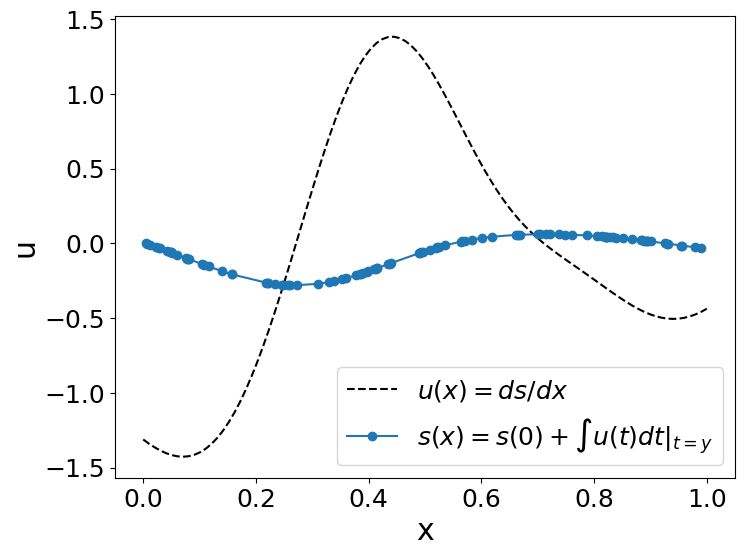

In [30]:
plot_us(x,u,y_train,s_train)

Now, we will have to create many functions for our testing and training dataset, so let's create a pair of programing-functions to generate one random function at a time.

In [31]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, m=100, P=1):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X =jnp.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L =jnp.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample =jnp.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t:jnp.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x =jnp.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y_train = random.uniform(key, (P,)).sort() 
    s_train = odeint(u_fn, 0.0,jnp.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train =jnp.tile(u, (P,1))

    return u_train, y_train, s_train


In [32]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X =jnp.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L =jnp.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample =jnp.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t:jnp.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x =jnp.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y =jnp.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u =jnp.tile(u, (P,1))

    return u, y, s 

## Data Generation

In [33]:
# Training Data
N_train = 10000 #Number of functions
m = 100 # number of input sensors
P_train = 1   # number of output sensors
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 

In [34]:
config.update("jax_enable_x64", True) # Enable double precision
keys = random.split(key_train, N_train) # Obtain 10000 random numbers

In [35]:
gen_fn = jit(lambda key: generate_one_training_data(key, m, P_train)) #lets call our function
u_train, y_train, s_train = vmap(gen_fn)(keys)

In [36]:
# Reshape the data
u_train =jnp.float32(u_train.reshape(N_train * P_train,-1))
y_train =jnp.float32(y_train.reshape(N_train * P_train,-1))
s_train =jnp.float32(s_train.reshape(N_train * P_train,-1))

In [37]:
# Testing Data
N_test = 1 # number of input samples 
P_test = m   # number of sensors 
key_test = random.PRNGKey(12345) # A different key 

In [38]:
keys = random.split(key_test, N_test)
gen_fn = jit(lambda key: generate_one_test_data(key, m, P_test))
u, y, s = vmap(gen_fn)(keys)

In [39]:
#Reshape the data
u_test =jnp.float32(u.reshape(N_test * P_test,-1))
y_test =jnp.float32(y.reshape(N_test * P_test,-1))
s_test =jnp.float32(s.reshape(N_test * P_test,-1))

In [40]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# DeepOnet

In [41]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. /jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b =jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs =jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs =jnp.dot(inputs, W) + b
      return outputs
  return init, apply

In [42]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        # Logger
        self.loss_log = []

    # Define opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs =jnp.sum(B * T)
        return outputs
      
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y

    # Define loss
    def loss(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N,1)
        # outputs: s, shape = (N,1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss =jnp.mean((outputs.flatten() - pred)**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                # Store loss
                self.loss_log.append(loss_value)

                # Print loss during training
                pbar.set_postfix({'Loss': loss_value})
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

# Evaluate our Operator

In [43]:
# Initialize model
# For vanilla DeepONet, shallower network yields better accuarcy.
branch_layers = [100, 100, 100] 
trunk_layers =  [1, 100, 100]

model = DeepONet(branch_layers, trunk_layers)

In [44]:
# Create data set
batch_size = 10000
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [45]:
# Train
model.train(dataset, nIter=40000)


  0%|          | 77/40000 [00:09<1:19:31,  8.37it/s, Loss=0.06323614756847547]


KeyboardInterrupt: 

In [ ]:
# Predict
params = model.get_params(model.opt_state)

In [ ]:
s_pred = model.predict_s(params, u_test, y_test)[:,None]

In [ ]:
s_y_pred = model.predict_s_y(params, u_test, y_test) # remember that s_y=ds/dy=u

In [ ]:
# Compute relative l2 error
error_s =jnp.linalg.norm(s_test - s_pred) /jnp.linalg.norm(s_test) 
error_u =jnp.linalg.norm(u_test[::P_test].flatten()[:,None] - s_y_pred) /jnp.linalg.norm(u_test[::P_test].flatten()[:,None]) 

In [ ]:
print(error_s,error_u)

0.0019666823801816335 0.093285374


## Visualize the results for the first function in our Testing Dataset

In [ ]:
idx=0
index =jnp.arange(idx * P_test,(idx + 1) * P_test)

error_u: 1.967e-03
error_s: 9.329e-02


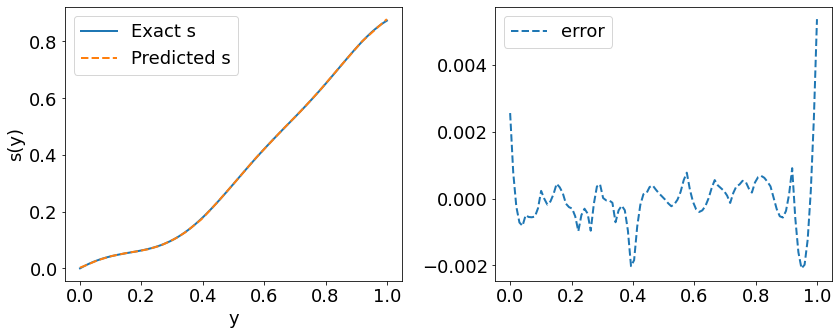

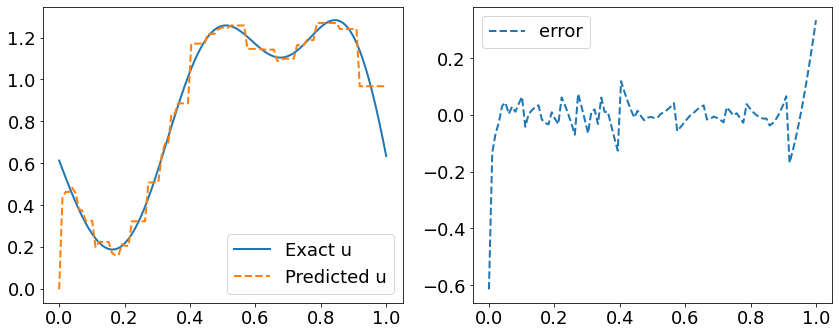

In [ ]:
# Compute the relative l2 error for one input sample 
error_u =jnp.linalg.norm(s_test[index, :] - s_pred[index, :], 2) /jnp.linalg.norm(s_test[index, :], 2) 
error_s =jnp.linalg.norm(u_test[::P_test][idx].flatten()[:,None] - s_y_pred[index, :], 2) /jnp.linalg.norm(u_test[::P_test][idx].flatten()[:,None], 2) 

print("error_u: {:.3e}".format(error_u))
print("error_s: {:.3e}".format(error_s))

# Visualizations
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.tight_layout()
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
plt.tight_layout()
plt.legend()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], s_y_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_y_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
plt.legend()
plt.tight_layout()
plt.show()

# Example

Lets obtain the anti-derivative of a trigonometric function. **However**, remember that this neural operator works for $x\in[0,1]$ when the antiderivative's initial value ($s(0)=0$). To fulfill that conditions, we will use $u(x)=cos(2\pi x),∀x\in[0,1]$.


So, we will evaluate our operator ($G$):


$$G:u(x)→s(x)=s(0)+\int_{0}^{x}u(t)dt$$

to $u(t)=cos(2\pi t)$:

$$s(x)=s(0)+\int_{0}^{x}cos(2\pi t)dt$$

Since $s(0)=0$, the answer would be (the integral of u):

$$s(x)=\frac{1}{2\pi}sin(2\pi x)$$



In [ ]:
#u_fn = lambda x, t:jnp.interp(t, X.flatten(), gp_sample)
u_fn = lambda t, x: -np.cos(2*np.pi*x)
# Input sensor locations and measurements
x =jnp.linspace(0, 1, m)
u = u_fn(None,x)
# Output sensor locations and measurements
y =random.uniform(key_train, (m,)).sort()

In [ ]:
# reshapte the data to be processed by our DeepOnet
u2=np.tile(u,100)
u2=np.float32(u2.reshape(N_test * P_test,-1))
y=y.reshape(len(y),1)

In [ ]:
s=model.predict_s(params, u2, y)[:,None]

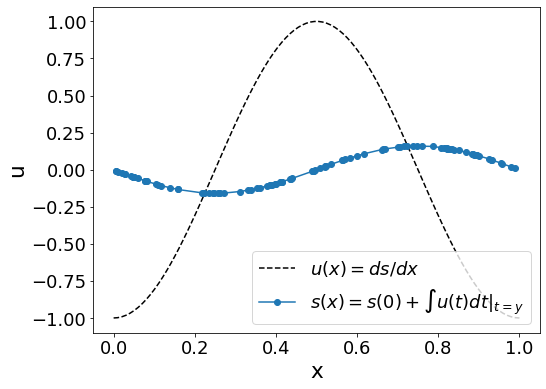

In [ ]:
plot_us(x,u,y,s)

# References

[1] Lu, L., Jin, P., & Karniadakis, G. E. (2019). Deeponet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operators. arXiv preprint arXiv:1910.03193.

[2] Wang, S., Wang, H., & Perdikaris, P. (2021). Learning the solution operator of parametric partial differential equations with physics-informed DeepONets. Science advances, 7(40), eabi8605.